In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)

/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sergio/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sergio/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scikit-allel 1.1.9


In [2]:
### Functions
def chrom2num(st):
    chrm = st.split(':')[0]
    pos = st.split(':')[1].split('-')

    pl = int(pos[0].replace(',',''))

    pr = int(pos[1].replace(',',''))
    
    return chrm, pl, pr

def plot_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(pos.min(), pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

def plot_variant_hist_2d(f1, f2, variants, downsample):
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax, offset=10)
    ax.hexbin(x, y, gridsize=20)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s joint distribution' % (f1, f2))

def plot_variant_hist(f, variants, bins=30, down=200):
    x = variants[f][:][::down]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

In [3]:
### VCF direct
ftlx = 'tracks/WGS-WES/Germline/FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1.vcf'
#ftlxg = 'tracks/WGS/Germline/FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1.vcf.gz'

# read VCF file, transform SNPEFF to separated fields (optional)
cs = allel.read_vcf(ftlx,fields='*', numbers={'ALT': 4},transformers=allel.ANNTransformer())


In [4]:
# variants data to DataFrame, transform SNPEFF to separated fields (optional)
var = allel.vcf_to_dataframe(ftlx,fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

In [5]:
# Genotype array to special class GenotypeArray
gt = allel.GenotypeArray(cs['calldata/GT'])
    ##- typical functions
    # gt.is_het()
    # gt.count_het(axis=1)
    # ac = gt.count_alleles()

In [6]:
#gt1 = gt.subset([2,7,9,12,45,67,124])
#gt2= gt.subset([3,8,10,13,46,68,125])

#gt3 = gt2.concatenate(gt1)



In [7]:
#gt1

In [8]:
print(sorted(var['ANN_Feature_Type'].unique()))
print(sorted(var['ANN_Transcript_BioType'].unique()))

['', 'intergenic_region', 'transcript']
['', 'protein_coding', 'pseudogene']


In [9]:
cod_var = var[var['ANN_Feature_Type']=='transcript']

In [10]:
print(len(var))
len(cod_var)
cod_var[['ANN_Gene_Name','ANN_Feature_Type', 'ANN_Transcript_BioType']].head()

1177356


ANN_Gene_Name ANN_Feature_Type ANN_Transcript_BioType
435          Xkr4       transcript         protein_coding
436          Xkr4       transcript         protein_coding
437          Xkr4       transcript         protein_coding
438          Xkr4       transcript         protein_coding
439          Xkr4       transcript         protein_coding

In [11]:
cod_ind=cod_var.index
cod_gt=gt[cod_ind]

## Now we have pair {cod_var, cod_gt} for transcripts only

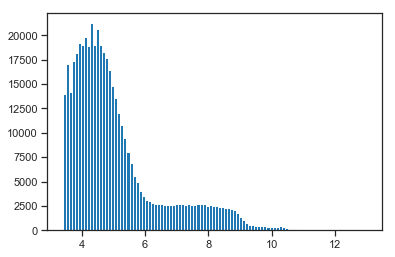

In [12]:
#cod_var.head(12)
a,b,c = plt.hist(np.log(cod_var['QUAL']), bins=100)

In [13]:
#cod_gt[2,:]

## Strip var data to region 

In [14]:
st  ='chr12:77,033,211-78,041,433'
c,l,r = chrom2num(st)
print(c,l,r)

chr12 77033211 78041433


In [15]:
var_reg = var[(var['CHROM']==c) & (var['POS']>l) & (var['POS']<r)]

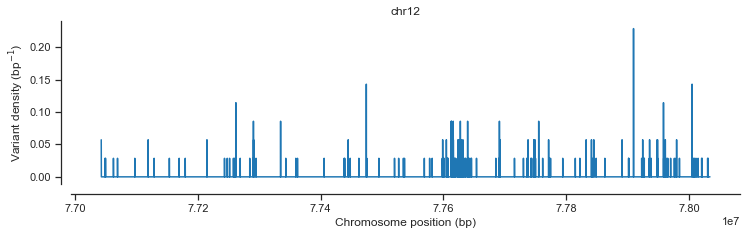

In [16]:
 plot_variant_density(var_reg['POS'], window_size=35, title=c)

In [17]:
### Plot density for all chromosomes
# for ch in df['CHROM'].unique():
#     dfc = df[df['CHROM']==ch]
#    plot_windowed_variant_density(dfc['POS'], window_size=100000, title=ch+' , raw variant density')

## Working with chunked table, we need HDF5 file

In [18]:
### Save to hdf5
#import sys
#allel.vcf_to_hdf5(ftlx,'FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1_Shrt.h5', 
#                  fields='*', alt_number=4,transformers=allel.ANNTransformer(),log=sys.stdout, vlen=False)

In [20]:
### HDF5 from VCF database
ftlxh5 ='tracks/WGS-WES/Germline/FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1_Shrt.h5'

# read HDF5 file
csh = h5py.File(ftlxh5,mode='r')
var_tb = allel.VariantChunkedTable(csh['variants'], 
                                   names=['CHROM', 'POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'ANN_AA_length',
                                             'ANN_Allele',
                                             'ANN_Annotation',
                                             'ANN_Annotation_Impact',
                                             'ANN_Feature_ID',
                                             'ANN_Feature_Type',
                                             'ANN_Gene_ID',
                                             'ANN_Gene_Name',
                                             'ANN_Rank',
                                             'ANN_Transcript_BioType','numalt'])

In [21]:
#a,b,c=plt.hist(var_tb['DP'][:], bins=10)
#csh['variants/REF']

## Now we can work with filters

In [22]:
#fltr_expr = '(QD > 5) & (MQ > 40) & (DP > 1500) & (DP < 3000)'
fltr_expr="ANN_Feature_Type==b'transcript'"

var_tb_fltr = var_tb.eval(fltr_expr)[:]

#var_tb
#var_tb_fltr
np.count_nonzero(var_tb_fltr)
#np.count_nonzero(~var_tb_fltr)

#list(csh['calldata'].keys())
#list(csh['variants'].keys())

473279

In [23]:
## apply filter
var_pass = var_tb.compress(var_tb_fltr)


## Genotype from HDF5 

In [24]:
list(csh['calldata'].keys())

['AD', 'DP', 'GQ', 'GT', 'MIN_DP', 'MQ0', 'PGT', 'PID', 'PL', 'RGQ', 'SB']

In [25]:
gth = allel.GenotypeChunkedArray(csh['calldata/GT'])
gth

<GenotypeChunkedArray shape=(1177356, 4, 2) dtype=int8 chunks=(65536, 4, 2)
   nbytes=9.0M cbytes=1.1M cratio=8.0
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [26]:
list(csh['samples'])

[b'AC3812', b'AC3813', b'AC3814', b'AC3815']

In [27]:
import pandas as pd
samples = pd.DataFrame({'sample':[b'AC3812', b'AC3813', b'AC3814', b'AC3815'], 'cell_type':['TAP','TAP','TLX3','TLX3']})
TLX = samples['cell_type'].isin(['TLX3'])
TAP = samples['cell_type'].isin(['TAP'])


## Subset genotype on transcrips and samples

In [28]:
gth_tlx = gth.subset(var_tb_fltr, TLX)
gth_tap = gth.subset(var_tb_fltr, TAP)

#### Now we have three tables: {var_pass, gth_tlx, gth_tap}  for transcripts only 

In [29]:
n_variants = len(var_pass)
pc_missing_tlx = gth_tlx.count_missing(axis=0)[:] * 100 / n_variants
pc_het_tlx = gth_tlx.count_het(axis=0)[:] * 100 / n_variants

pc_missing_tap = gth_tap.count_missing(axis=0)[:] * 100 / n_variants
pc_het_tap = gth_tap.count_het(axis=0)[:] * 100 / n_variants



print('TLX3 missing = ', pc_missing_tlx)
print('TLX3 hetero = ', pc_het_tlx)

print('TAP missing = ', pc_missing_tap)
print('TAP hetero = ', pc_het_tap)

TLX3 missing =  [0.81410753 0.82889797]
TLX3 hetero =  [62.95525472 55.49475045]
TAP missing =  [0.79487998 0.87348055]
TAP hetero =  [21.04107725 20.86655017]


In [30]:
tlx_seg = gth_tlx.count_alleles().count_segregating()
tap_seg = gth_tap.count_alleles().count_segregating()

print('TLX segregating = ', tlx_seg)
print('TAP segregating = ', tap_seg)

TLX segregating =  418534
TAP segregating =  126927


# CASE 1: Variants for list of genes - tumor suppressors

In [40]:
import EnrichRLib as erl

tall_sup = erl.read_gmt('gene_lists/T-ALL_suppressor.gmt')
gl = tall_sup['T-ALL-suppressor']

gl

['BCL11B',
 'RUNX1',
 'TET1',
 'EZH2',
 'FBXW7',
 'PTEN',
 'FAT1',
 'LEF1',
 'GATA3',
 'ETV6',
 'WT1',
 'PTPN2',
 'CDKN1B',
 'RB1',
 'DNM2',
 'CNOT3',
 'RPL5',
 'RPL10',
 'SH2B3',
 'NF1',
 'PHF6']

In [32]:
# working with pair {cod_var, cod_gt}
cod_var.loc[:,'ANN_Gene_Name'] = cod_var['ANN_Gene_Name'].str.upper()

/home/sergio/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
#cod_var['ANN_Gene_Name'].head()

cod_var_gs = cod_var.loc[cod_var['ANN_Gene_Name'].isin(gl)]

In [34]:
cod_gt_gs = cod_gt[cod_var_gs.index]


In [35]:
# TLX3 count homo/hetero
tlx_homalt = cod_gt_gs[:,2:].is_hom_alt()[:]
cod_gt_gs[:,2:].count_hom_alt()


6

In [36]:
# TAP count homo/hetero
tap_homalt = cod_gt_gs[:,:2].is_hom_alt()[:]

cod_gt_gs[:,:2].count_hom_alt()

11

In [37]:
cod_var_gs_r = cod_var_gs.reset_index()

# tlx
cod_var_gs_tlx = cod_var_gs_r[tlx_homalt]

# tap
cod_var_gs_tap = cod_var_gs_r[tap_homalt]

In [38]:
cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'ALT_2',
        'ANN_Annotation',
        'ANN_Annotation_Impact',
        'ANN_Feature_ID',
        'ANN_Feature_Type',
        'ANN_Gene_ID',
        'ANN_Gene_Name',
        'ANN_Rank',
        'ANN_Transcript_BioType']

cod_var_gs_tlx[cols]

CHROM        POS REF ALT_1 ALT_2      ANN_Annotation  \
59   chr12  109154426   G     A        synonymous_variant   
59   chr12  109154426   G     A        synonymous_variant   
130  chr12  109182765   T     C            intron_variant   
173  chr12  109202497   A     T            intron_variant   
510   chr6  134092483   C     G            intron_variant   
510   chr6  134092483   C     G            intron_variant   

    ANN_Annotation_Impact  ANN_Feature_ID ANN_Feature_Type ANN_Gene_ID  \
59                    LOW  NM_001079883.1       transcript      Bcl11b   
59                    LOW  NM_001079883.1       transcript      Bcl11b   
130              MODIFIER  NM_001079883.1       transcript      Bcl11b   
173              MODIFIER  NM_001079883.1       transcript      Bcl11b   
510              MODIFIER     NM_007961.4       transcript        Etv6   
510              MODIFIER     NM_007961.4       transcript        Etv6   

    ANN_Gene_Name  ANN_Rank ANN_Transcript_BioType  
59         BCL11B         4         protein_coding  
59         BCL11B         4         protein_coding  
130        BCL11B         3         protein_coding  
173        BCL11B         3         protein_coding  
510          ETV6         2         protein_coding  
510          ETV6         2         protein_coding

In [39]:
cod_var_gs_tap[cols]

CHROM        POS      REF            ALT_1 ALT_2      ANN_Annotation  \
59   chr12  109154426        G                A        synonymous_variant   
59   chr12  109154426        G                A        synonymous_variant   
78   chr12  109168286        G                A            intron_variant   
130  chr12  109182765        T                C            intron_variant   
173  chr12  109202497        A                T            intron_variant   
256  chr12  109240672    CTTTT                C            intron_variant   
426   chr6  134004385        G  GTATATATATATATA            intron_variant   
426   chr6  134004385        G  GTATATATATATATA            intron_variant   
510   chr6  134092483        C                G            intron_variant   
510   chr6  134092483        C                G            intron_variant   
530   chr6  134178978  GCACACA                G            intron_variant   

    ANN_Annotation_Impact  ANN_Feature_ID ANN_Feature_Type ANN_Gene_ID  \
59                    LOW  NM_001079883.1       transcript      Bcl11b   
59                    LOW  NM_001079883.1       transcript      Bcl11b   
78               MODIFIER  NM_001079883.1       transcript      Bcl11b   
130              MODIFIER  NM_001079883.1       transcript      Bcl11b   
173              MODIFIER  NM_001079883.1       transcript      Bcl11b   
256              MODIFIER  NM_001079883.1       transcript      Bcl11b   
426              MODIFIER     NM_007961.4       transcript        Etv6   
426              MODIFIER     NM_007961.4       transcript        Etv6   
510              MODIFIER     NM_007961.4       transcript        Etv6   
510              MODIFIER     NM_007961.4       transcript        Etv6   
530              MODIFIER     NM_007961.4       transcript        Etv6   

    ANN_Gene_Name  ANN_Rank ANN_Transcript_BioType  
59         BCL11B         4         protein_coding  
59         BCL11B         4         protein_coding  
78         BCL11B         3         protein_coding  
130        BCL11B         3         protein_coding  
173        BCL11B         3         protein_coding  
256        BCL11B         1         protein_coding  
426          ETV6         1         protein_coding  
426          ETV6         1         protein_coding  
510          ETV6         2         protein_coding  
510          ETV6         2         protein_coding  
530          ETV6         3         protein_coding

# CASE 2: Variant in enhancers

In [20]:
import pybedtools as pb

In [26]:
enh = pb.BedTool('tracks/Enhancers_ChromHMM.bed')
enh_df = enh.to_dataframe()

In [57]:
#enh_df.head()

In [31]:
ftlx = 'tracks/WGS-WES/Germline/FERRIER_09_Germline.allchr.snpEff.p.SAL.SAL10_1.vcf'
var_b = pb.BedTool(ftlx)

In [42]:
var_enh = (var_b + enh).saveas('tracks/WGS-WES/Germline/Vars_Enh_noHeader.vcf')

In [58]:
len(var_enh)

6104

In [44]:
# Concat with header

# !cat tracks/WGS-WES/Germline/Germline_header.txt tracks/WGS-WES/Germline/Vars_Enh_noHeader.vcf > tracks/WGS-WES/Germline/Vars_Enh.vcf

In [49]:
var_enh_df = var_enh.to_dataframe(names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','AC3812','AC3813','AC3814','AC3815'])

In [54]:
var_enh_df.head()

CHROM       POS ID    REF     ALT     QUAL             FILTER  \
0  chr1   6457367  .      G       A    75.30               PASS   
1  chr1   9227118  .      G       A  3553.94                map   
2  chr1  10275750  .  GTCTC       G   109.29               PASS   
3  chr1  10315189  .      T       C   129.33               PASS   
4  chr1  10316603  .      G  GTCTTT  1767.94  mrd15;mrd20;mrd30   

                                                INFO          FORMAT  \
0  AC=1;AF=0.125;AN=8;BaseQRankSum=-1.432e+00;Cli...  GT:AD:DP:GQ:PL   
1  AC=4;AF=0.500;AN=8;BaseQRankSum=-3.551e+00;Cli...  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.125;AN=8;BaseQRankSum=-1.939e+00;Cli...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.125;AN=8;BaseQRankSum=-1.779e+00;Cli...  GT:AD:DP:GQ:PL   
4  AC=4;AF=0.500;AN=8;BaseQRankSum=0.605;Clipping...  GT:AD:DP:GQ:PL   

                       AC3812                       AC3813  \
0   0/0:41,0:41:99:0,103,1489     0/0:43,0:43:99:0,99,1515   
1  0/1:49,31:80:99:803,0,1598  0/1:47,46:93:99:1249,0,1453   
2   0/0:38,0:38:99:0,108,1620    0/0:41,0:41:99:0,102,1481   
3   0/0:39,0:39:99:0,100,1486    0/0:40,0:40:99:0,102,1511   
4   0/1:13,12:25:99:451,0,645      0/1:8,9:17:99:395,0,416   

                       AC3814                      AC3815  
0      0/0:47,0:47:0:0,0,1425   0/1:38,7:45:99:105,0,1343  
1  0/1:51,30:81:99:726,0,1561  0/1:42,33:75:99:808,0,1327  
2   0/1:48,7:55:99:150,0,1958   0/0:39,0:39:99:0,103,1382  
3   0/1:39,9:48:99:161,0,1345    0/0:41,0:41:53:0,53,1429  
4     0/1:4,9:13:99:441,0,177   0/1:10,13:25:99:513,0,520

In [59]:
#var_enh_df['INFO'][16]

In [ ]:
#plot_variant_hist_2d('QD', 'MQ', var, downsample=500)



#“MQ” is average mapping quality across all samples.
#plot_variant_hist('MQ', var, down=2)

#“QD” is a slightly odd statistic but turns out to be very useful 
# for finding poor quality SNPs. Roughly speaking, high numbers 
# mean that evidence for variation is strong (concentrated), 
# low numbers mean that evidence is weak (dilute).


#x = var['QD'][:][::1000]
#plot_variant_hist('QD', var, bins=30, down=500)

#ac = gt.count_alleles()
#ac

